## Customer Segmentation project using clustering (K-Means) and RFM analysis

In [39]:
# Setting up libery

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [41]:
# Data Load
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Data Cleaning

In [42]:
#  Searching missing and duplicate values if present
df.isnull().sum()
df.duplicated().sum()

np.int64(0)

# Droping irrelevent columns for our use (CustomerID)

In [43]:
df = df.drop("CustomerID", axis  =1)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


# Exploratory Data Analysis (EDA)

In [45]:
print(df.describe())

              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000


# ⭐ Visualizations

# Distribution of Numerical Features

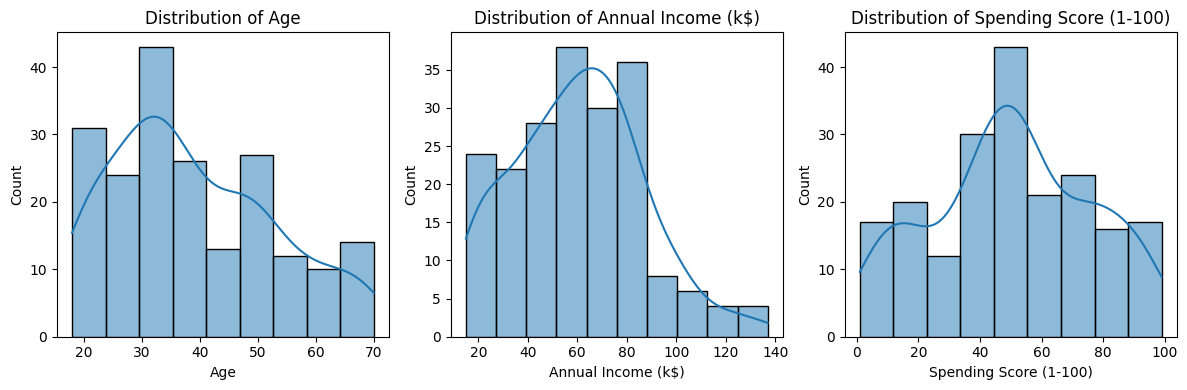

In [46]:
plt.figure(figsize=(12, 4))

for i , col in enumerate(['Age', 'Annual Income (k$)', 'Spending Score (1-100)']):
    plt.subplot(1,3, i+1)
    sns.histplot(df[col] , kde = True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 👥 Gender Analysis

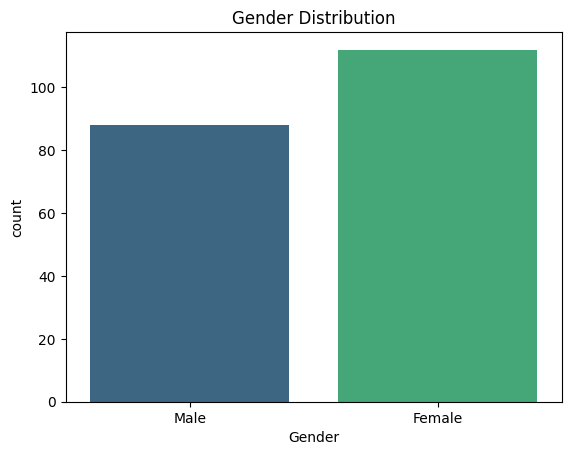

In [47]:
sns.countplot(x = 'Gender' ,
              data = df , 
              palette='viridis' , 
              hue = 'Gender',
             legend= False)
plt.title('Gender Distribution')
plt.show()

# 😍 Pairplot for Relationships

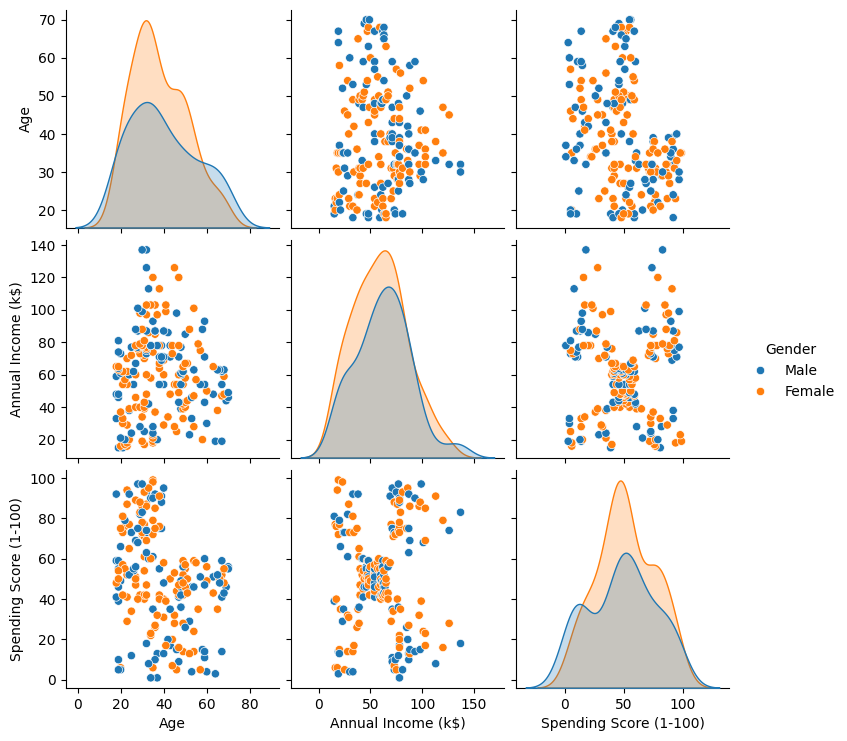

In [48]:
sns.pairplot(df , hue = 'Gender' , diag_kind='kde')
plt.show()

# Feature Selection & Scaling

# For clustering( income + spending Score)

In [49]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optimal Clusters (Elbow Method)

In [51]:
wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve

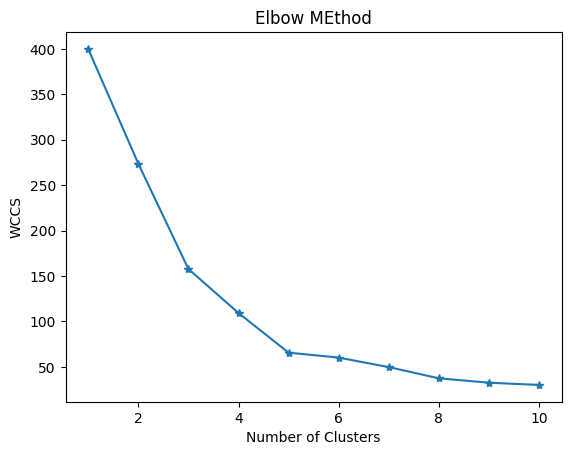

In [52]:
plt.plot(range(1,11) , wcss , marker = '*')
plt.xlabel('Number of Clusters')
plt.ylabel('WCCS')
plt.title('Elbow MEthod')
plt.show()

In [53]:
# Optimal clusters: 5 (where the elbow bends).

# Apply K-Means Clustering

In [54]:
kmeans = KMeans(n_clusters=5, init = 'k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters

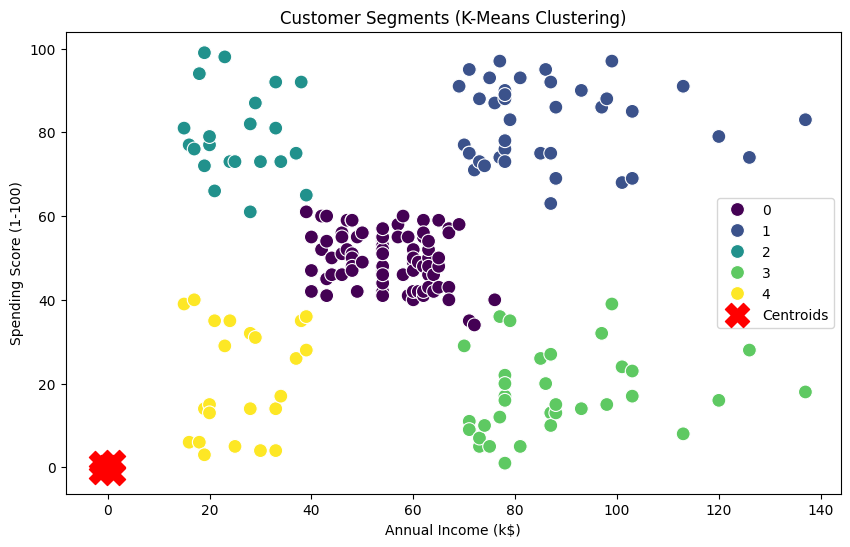

In [55]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    x = 'Annual Income (k$)',
    y='Spending Score (1-100)',
    data = df ,
    palette='viridis',
    hue = 'Cluster',
    s =100
)
plt.scatter(
    kmeans.cluster_centers_[:,0],
    kmeans.cluster_centers_[:,1],
    s =300,
    c = 'red',
    marker = 'X',
    label = 'Centroids'
)

plt.title('Customer Segments (K-Means Clustering)')
plt.legend()
plt.show()

### Cluster Interpretation:

- **Cluster 0**: Low Income, Low Spending  
  (Budget-conscious customers with limited purchasing power)

- **Cluster 1**: High Income, Low Spending  
  (Wealthy but conservative spenders - potential for premium product targeting)

- **Cluster 2**: Moderate Income, Moderate Spending  
  (Average customers - focus on retention)

- **Cluster 3**: High Income, High Spending (Target Group)**  
  (High-value customers - prioritize marketing efforts and loyalty programs)

- **Cluster 4**: Low Income, High Spending  
  (May represent younger demographics or those with different spending priorities)

# RFM Analysis (Adapted)

### Customer Segmentation Using Income (Monetary) & Spending Score (Frequency Proxy)

Since we lack explicit "Recency" data, we use:
- **Spending Score** as a proxy for **Frequency** (higher score = more frequent purchases)
- **Annual Income** as the **Monetary** component

Clusters are interpreted as:

### Score Customers (1-5 scale):

In [56]:
df['F_Score'] = pd.qcut(df['Spending Score (1-100)'] , q = 5 ,
                        labels=[1,2,3,4,5])

df['M_Score'] = pd.qcut(df['Annual Income (k$)'] , q =5 ,
                        labels=[1,2,3,4,5])

df['RFM_Score'] = df['F_Score'].astype(int) + df['M_Score'].astype(int)

## Segment Customers:

In [57]:
segment_labels = {
    2: 'Hibernating', 3: 'At Risk', 4: 'Need Attention',
    5: 'Loyal', 6: 'Promising', 7: 'Potential Loyalists',
    8: 'Champions', 9: 'High Spenders', 10: 'Top Customers'
}
df['RFM_Segment'] = df['RFM_Score'].map(segment_labels)

## Visualize RFM Segments

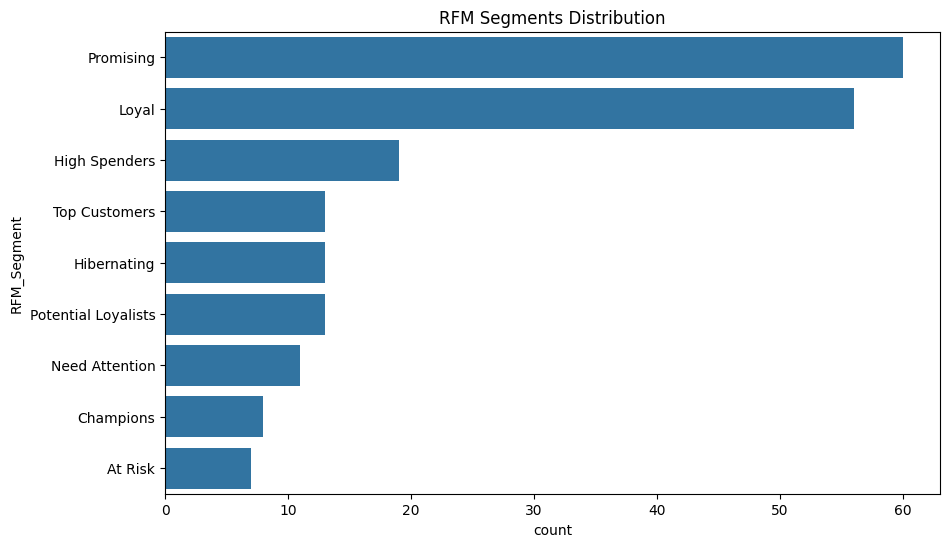

In [58]:
plt.figure(figsize=(10, 6))
sns.countplot(y='RFM_Segment', 
              data=df, order=df['RFM_Segment'].value_counts().index)
plt.title('RFM Segments Distribution')
plt.show()

## PCA for 3D Clustering
--**Import PCA and Prepare Data:

In [59]:
from sklearn.decomposition import PCA

X_pca = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
X_pca_scaled = StandardScaler().fit_transform(X_pca)

In [60]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pca_scaled)
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2', 'PC3'])

df_pca['Cluster'] = df['Cluster']

## 3D Cluster Visualization:

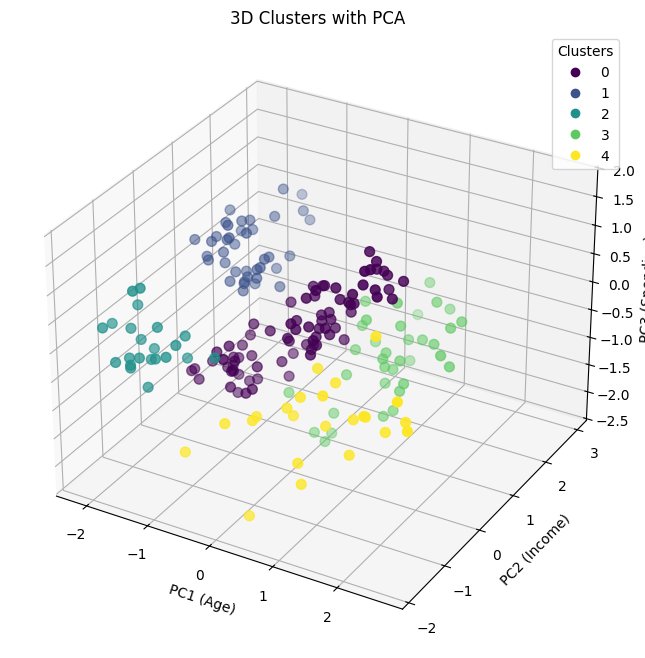

In [61]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(
    111,
    projection = '3d'
)

scatter = ax.scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    df_pca['PC3'],
    c = df_pca['Cluster'],
    cmap  = 'viridis',
    s =50
)
ax.set_xlabel('PC1 (Age)')
ax.set_ylabel('PC2 (Income)')
ax.set_zlabel('PC3 (Spending)')
plt.title('3D Clusters with PCA')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

## Demographic (Age/Gender) Analysis

-- Age Binning for Segmentation:

In [62]:
bins = [0 , 20 , 35, 50 ,100]
labels = ['Gen-Z', 'Millennials', 'Gen-X', 'Boomers']
df['Age_Group'] = pd.cut(df['Age'], bins= bins , labels= labels)

- **Gender Distribution per Cluster:

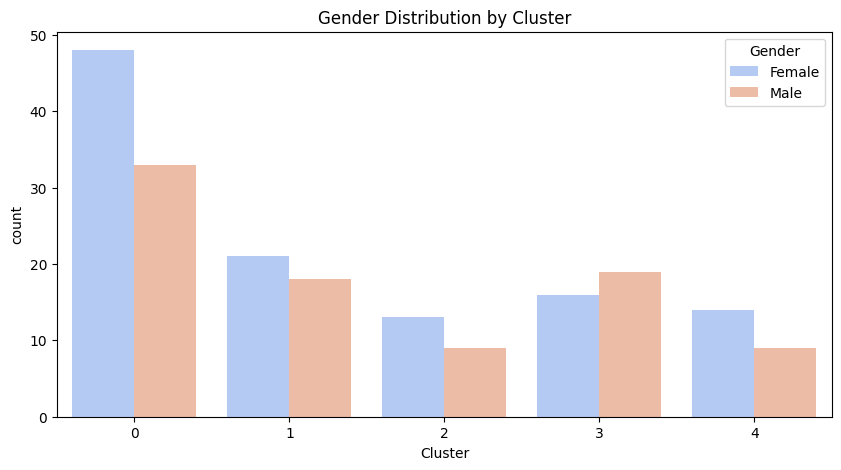

In [64]:
plt.figure(figsize=(10,5))
sns.countplot(
    x = 'Cluster',
    hue = 'Gender',
    data = df,
    palette= 'coolwarm'
)
plt.title('Gender Distribution by Cluster')
plt.show()

- **Age Group Analysis:

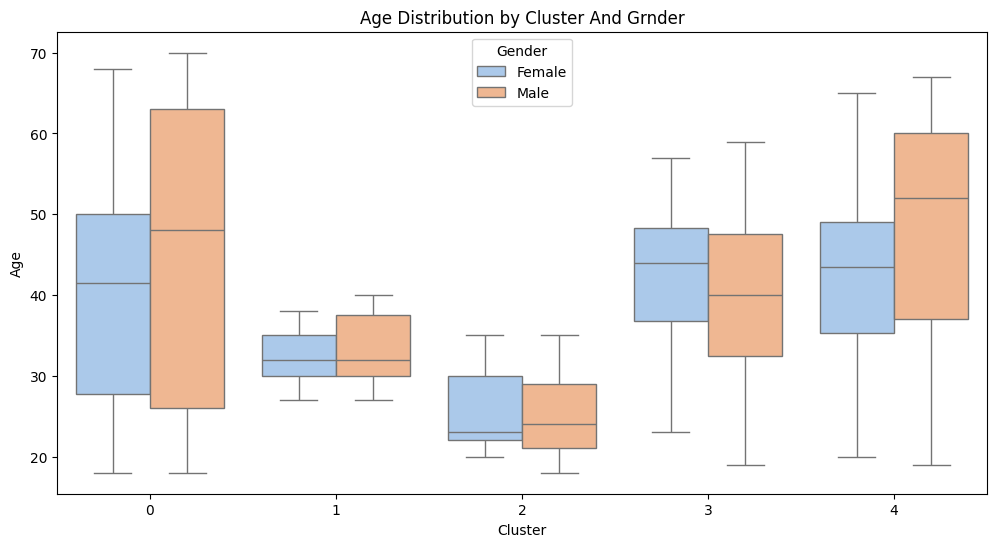

In [65]:
plt.figure(figsize=(12,6))
sns.boxplot(
    x = 'Cluster',
    y = 'Age',
    data = df,
    hue = 'Gender',
    palette='pastel'
)
plt.title('Age Distribution by Cluster And Grnder')
plt.show()

In [67]:
pd.crosstab(df['Cluster'], df['Age_Group'] , normalize='index')

Age_Group,Gen-Z,Millennials,Gen-X,Boomers
Cluster,,,,
0,0.111111,0.271605,0.308642,0.308642
1,0.000000,0.743590,0.256410,0.000000
2,0.136364,0.863636,0.000000,0.000000
3,0.085714,0.200000,0.514286,0.200000
4,0.086957,0.173913,0.391304,0.347826
